In [1]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim, utils
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

from sklearn import metrics
from matplotlib import pyplot as plt

In [2]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels):
    self.x = images
    self.y =  labels

  def __getitem__(self, i):
    return (self.x[i], self.y[i])

  def __len__(self):
    return len(self.x)

class CustomModel(nn.Module):
  def __init__(self):
    super(CustomModel, self).__init__()
    self.layer1 = nn.Linear(784, 10)
    self.layer2 = nn.Linear(10, 128)
    self.layer3 = nn.Linear(128, 45)
    self.layer4 = nn.Linear(45, 10)
    #Add more layers

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.relu(self.layer3(x))
    x = self.layer4(x)

    #Add more layers
    return x

def trainingLoop(modeltoTrain, trainDataLoader, lossFunc, optimize, EPOCHS):
  modeltoTrain.train() #puts our model in training mode; very important
  for current_epoch in range(EPOCHS):
      for batch_inputs, actualClasses in iter(trainDataLoader):
          #Our batches are nx28x28 tensors, but our model expects a nx784 tensor. Where does nx28x28 come from, and what should we do to fix this problem?
          batch_inputs = torch.reshape(batch_inputs, [16, 784])

          predictions = modeltoTrain(batch_inputs)

          #the loss function has two inputs: the predictions made by the model and the actual classes it was supposed to predict
          #Enter those parameters into the loss function
          currentLoss = lossFunc(predictions, actualClasses)
          currentLoss.backward() #do the backpropagation
          optimize.step() #actually adjust our model parameters to make our model slightly better
          optimize.zero_grad() #we need to reset our optimizer every time we call it because we recalculate our gradients on every iteration

      print("Epoch {} over; loss at the end of the epoch: {}".format(current_epoch+1, currentLoss.item()))

def evaluateModel(modelToEval, testDataLoader):
  modelToEval.eval() #puts our model in eval mode (very important)
  allPreds = torch.Tensor([])
  allAnswers = torch.Tensor([])

  for batch_inputs, actualClasses in iter(testDataLoader):
    batch_inputs = torch.reshape(batch_inputs, [16, 784])
    predicted_outputs = modelToEval(batch_inputs)

    predicted_classes = predicted_outputs.argmax(axis = 1) #figures out which classes our model is predicting
    allPreds = torch.cat([allPreds, predicted_classes]) #Add the list of predicted outputs to our running total
    allAnswers = torch.cat([allAnswers, actualClasses]) #Add the list of true classes to our running total
  return allPreds, allAnswers #We will use the predicted outputs and the real classes to judge our model

In [3]:
BATCH_SIZE = 16

trainData = datasets.MNIST("./data", train = True, transform = torchvision.transforms.ToTensor(), download = True)
testData = datasets.MNIST("./data", transform = torchvision.transforms.ToTensor(), download = True)

trainDataLoader = torch.utils.data.DataLoader(trainData, batch_size = BATCH_SIZE, shuffle = True)
testDataLoader = torch.utils.data.DataLoader(testData, batch_size = BATCH_SIZE, shuffle = True) #fill in the parameters for your testDataLoader using the trainDataLoader as a reference

model = CustomModel()

initialModelResults = evaluateModel(model, testDataLoader)
trainingLoop(model,
             trainDataLoader,
             nn.CrossEntropyLoss(),
             torch.optim.Adam(model.parameters(), lr = 0.01),
             2)
finalModelResults = evaluateModel(model, testDataLoader)
cm_before = metrics.confusion_matrix(
    initialModelResults[1],  # true labels
    initialModelResults[0]   # predicted labels
)

cm_after = metrics.confusion_matrix(
    finalModelResults[1],
    finalModelResults[0]
)

print("Confusion matrix BEFORE training:")
print(cm_before)

print("\nConfusion matrix AFTER training:")
print(cm_after)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.30MB/s]


Epoch 1 over; loss at the end of the epoch: 0.153786763548851
Epoch 2 over; loss at the end of the epoch: 0.3282228410243988
Confusion matrix BEFORE training:
[[   0 5855    0    0    0    0    0    0   47   21]
 [   0 6641    0    0    0    0    0    0  101    0]
 [   0 5916    0    0    0    0    0    0   41    1]
 [   0 6051    0    0    0    0    0    0   77    3]
 [   0 5838    0    0    0    0    0    0    4    0]
 [   0 5220    0    0    0    0    0    0  198    3]
 [   0 5899    0    0    0    0    0    0   19    0]
 [   0 6220    0    0    0    0    0    0   37    8]
 [   0 5765    0    0    0    0    0    0   85    1]
 [   0 5924    0    0    0    0    0    0   25    0]]

Confusion matrix AFTER training:
[[5437    4   16    0   22  295  120   10   19    0]
 [   0 6373   86    5   45   21   12   24  168    8]
 [  25   34 5261   28   76  126  217   67  124    0]
 [   3  126  223 4247   16  980   19   45  433   39]
 [  17    6    5    0 5371   30  120    8   10  275]
 [  89   16

True class: 7
Prediction: 7


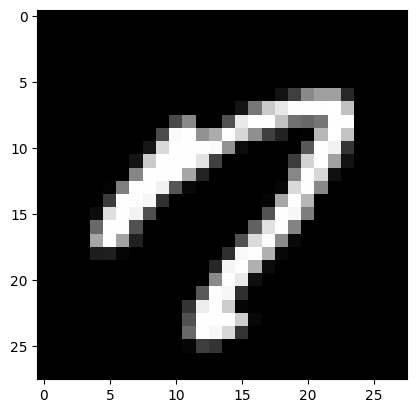

In [4]:
import random
placeInBatch = random.randint(0, BATCH_SIZE-1)
images, classes = iter(testDataLoader).__next__()

image = images[placeInBatch]
trueClass = classes[placeInBatch]

plt.imshow(image[0], cmap = "gray")
print("True class:", trueClass.item())
print("Prediction:", model(image.reshape((1, 784))).argmax(axis = 1).item())